## Image-based AI - Predicting Age

We show how AI models can make predictions from images, and show image-based explanations (salience maps). 

The case study we use is the prediction of age from images of the face. The distinction between predicted age and biological age (from various prediction mediums) is often considered to be a biomarker with relevance to health -- for a recent example of this type of study, see https://pubmed.ncbi.nlm.nih.gov/38190540/. 

Here, we focus only on the readily obtainable images of the face. 

This exercise is based on https://medium.com/@thisara.weerakoon2001/age-classification-using-transfer-learning-vgg16-d2f240f67d26 


### Install required libraries 

In [5]:
! pip install numpy==1.26.4 matplotlib opencv-python scikit-learn torch keras visualkeras tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.4/481.4 kB 1.2 MB/s eta 0:00:00a 0:00:01m


In [1]:
import os

import random

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from sklearn.model_selection import train_test_split

from keras import utils
from keras.models import Model,Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.applications.vgg16 import preprocess_input,VGG16
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,EarlyStopping

import visualkeras
from PIL import ImageFont


### Load images dataset

We use the  UTKFace dataset (https://www.kaggle.com/datasets/jangedoo/utkface-new?resource=download).



Loaded 23708 images.


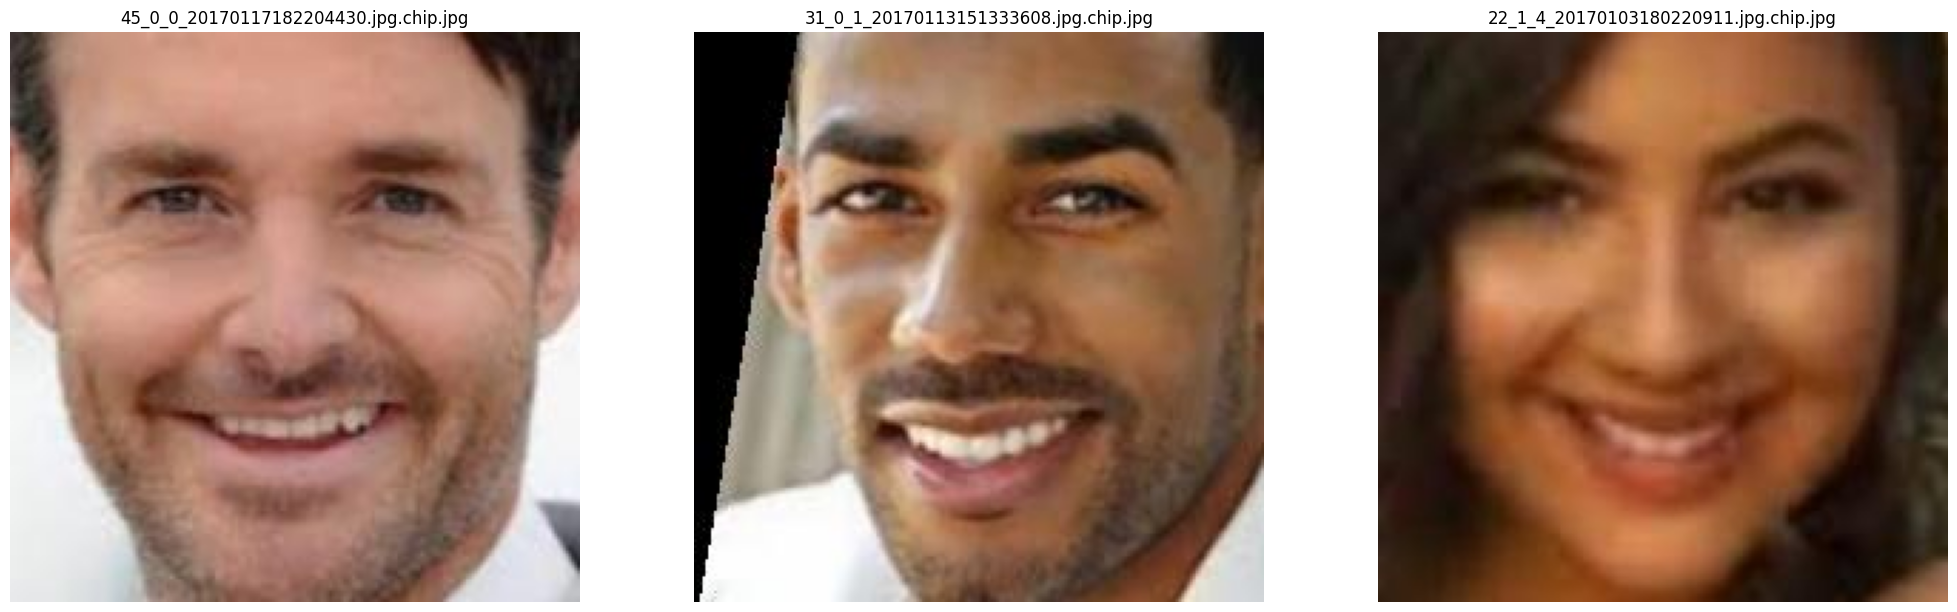

In [2]:
img_dir = "utkface_aligned_cropped/UTKFace"

all_img_names=os.listdir(img_dir)

print(f"Loaded {len(all_img_names)} images.")

random_range = random.sample(range(len(all_img_names)), 5)

# Create a Matplotlib figure.
plt.figure(figsize=(25,25))

# Generate a list of 5 random values. The values should be less than number of images in dataset. 
random_range = random.sample(range(len(all_img_names)), 3)

#Iterate through random values
for counter, random_index in enumerate(random_range, 1):
    
    #Name of the selected image
    img_name=all_img_names[random_index]
    
    #Path of the selected image
    img_path=os.path.join(img_dir,img_name)
    
    #Read the selected image in BGR format
    bgr_img=cv2.imread(img_path)
    
    #Convert it into RGB format
    rgb_img=cv2.cvtColor(bgr_img,cv2.COLOR_BGR2RGB)
    
    
    #Display the selected image
    plt.subplot(1, 3, counter)
    plt.imshow(rgb_img)
    plt.title(img_name)
    plt.axis('off')

plt.show()
plt.close()

### Some image preprocessing is required 



In [3]:
img_height=224
img_width=224

def image_preprocessing(img_path):
    #Read the image
    img=cv2.imread(img_path)
    
    #Resize the image 
    resized_img=cv2.resize(img,(img_height,img_width))
    
    #Normalize the image
    normalized_img=resized_img/255
    
    return normalized_img


def label_extraction(img_name):
    
    '''
    This function will extract age from image name and return the class index by performing integer division (by 25).
    Args:
        img_name: The name of the image.
    Returns:
        class_index: An integer representing the age class.
    '''
    #Extract age 
    age=int(img_name.split("_")[0])
    
    #Class index dividing by 25
    class_index=age//25
    
    return class_index


def create_dataset():
    
    '''
    This function will create the dataset.
    Returns:
        features:  A list containing the preprocessed images.
        labels:    A list containing the class indexes.
    '''
    
    #Declare empty lists to store features and labels.
    
    features=[]
    labels=[]
    
    for img_name in all_img_names:
        
        #Path of the image
        img_path=os.path.join(img_dir,img_name)
            
        #Get the preprocessed image
        preprocessed_img=image_preprocessing(img_path)
            
        #Get the class index
        class_index=label_extraction(img_name)
            
        #Append data into appropriate lists
        features.append(preprocessed_img)
        labels.append(class_index)
        
            
    #Convert lists to numpy arrays
    features=np.asarray(features)
    labels=np.asarray(labels)
    
    return features,labels

#Create the dataset
features,labels=create_dataset()

encoded_labels=utils.to_categorical(labels)

In [4]:
seed_constant = 42

# Split the Data into Train ( 90% ) and Test Set ( 10% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, encoded_labels,
                                                                            test_size = 0.1, shuffle = True,
                                                                            random_state = seed_constant)

In [5]:
# Save the preprocessed dataset so that we don't have to preprocess it again -- actually it saves HUGE, maybe not worth it... let's see... 
#import pickle
#PIK = "utkface-dataset.dat"

#data = [features_train, features_test, labels_train, labels_test]
#with open(PIK, "wb") as f:
#    pickle.dump(data, f)
#with open(PIK, "rb") as f:
#    print pickle.load(f)

In [6]:

#add preprocessing layer at the front of VGG16
vgg = VGG16(input_shape=features_train.shape[1:], weights='imagenet', include_top=False)

#Prevent training already trained layers 
for layer in vgg.layers:
  layer.trainable = False

#Add flatten layer
x = Flatten()(vgg.output)

#More Dense layers

#Use weight regularization(L2 vector norm) and dropout layers to reduce overfitting
x=Dense(1000,activation="relu",kernel_regularizer=l2(0.001))(x)
x=Dropout(0.5)(x)

x=Dense(256,activation="relu",kernel_regularizer=l2(0.001))(x)
x=Dropout(0.5)(x)

#Dense layer with number of nuerons equals to number of classes.
prediction = Dense(labels_train.shape[1], activation='softmax')(x)

#Create the model object
model = Model(inputs=vgg.input, outputs=prediction)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │    25,089,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,28

 Total params: 40,061,229 (152.82 MB)

 Trainable params: 25,346,541 (96.69 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)

# checkpoint
#filepath="weights.best.hdf5"
filepath="weights.best.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#Callbacks
callbacks_list=[early_stopping_callback,checkpoint]

# Compile the model and specify loss function, optimizer and metrics values to the model
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])

# Start training the model.
history = model.fit(x = features_train, y = labels_train, epochs = 50, 
                    shuffle = True, validation_split = 0.1, 
                    callbacks = callbacks_list )

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5170 - loss: 2.8254
Epoch 1: val_accuracy improved from -inf to 0.70665, saving model to weights.best.keras
601/601 ━━━━━━━━━━━━━━━━━━━━ 1155s 2s/step - accuracy: 0.5171 - loss: 2.8237 - val_accuracy: 0.7067 - val_loss: 1.0970
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6175 - loss: 1.1184
Epoch 2: val_accuracy did not improve from 0.70665
601/601 ━━━━━━━━━━━━━━━━━━━━ 1149s 2s/step - accuracy: 0.6175 - loss: 1.1184 - val_accuracy: 0.7048 - val_loss: 0.9382
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6417 - loss: 0.9891
Epoch 3: val_accuracy did not improve from 0.70665
601/601 ━━━━━━━━━━━━━━━━━━━━ 1144s 2s/step - accuracy: 0.6417 - loss: 0.9891 - val_accuracy: 0.7020 - val_loss: 0.8912
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6463 - loss: 0.9688
Epoch 4: val_accuracy did not improve from 0.70665
601/601 ━━━━━━━━━━━━━━━━━━━━ 1206s 2s/step - accuracy: 0.6463 

In [34]:
# Fix a bug in keras / progbar.py
#! pip show tensorflow
#! pip show keras

#import keras

#import importlib

# make changes to example.py file

#importlib.reload(keras)



<module 'keras' from '/opt/miniconda3/envs/image-faceage/lib/python3.12/site-packages/keras/__init__.py'>

In [8]:
# load weights of model with best validation accuracy
model.load_weights("weights.best.keras")

In [ ]:
model_evaluation_history_base = model.evaluate(features_test, labels_test)

model_evaluation_history = model.evaluate(features_test, labels_test)

In [10]:
model.save("best_val_acc_model.keras")

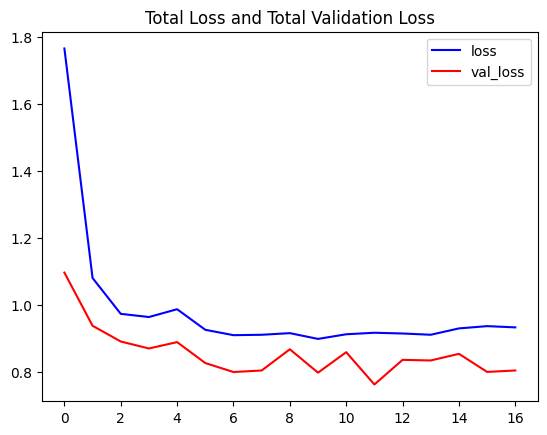

In [14]:
# Construct a range object 
epochs = range(len(history.history["loss"]))
# Plot the Graph.
plt.plot(epochs, history.history["loss"], 'blue', label = "loss")
plt.plot(epochs, history.history["val_loss"], 'red', label ="val_loss")
# Add title 
plt.title("Total Loss and Total Validation Loss")
# Add legend 
plt.legend()
plt.show()
plt.close()

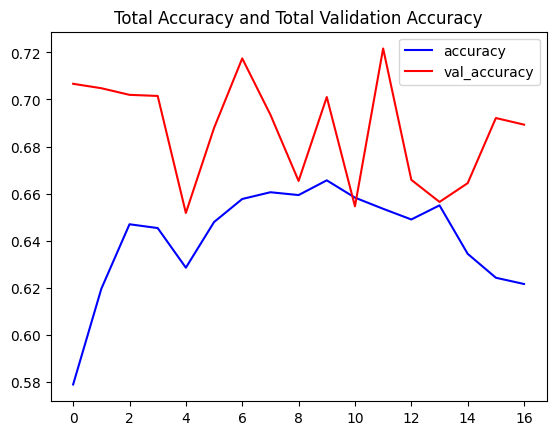

In [15]:
# Construct a range object 
epochs = range(len(history.history["accuracy"]))
# Plot the Graph.
plt.plot(epochs, history.history["accuracy"], 'blue', label = "accuracy")
plt.plot(epochs, history.history["val_accuracy"], 'red', label ="val_accuracy")
# Add title 
plt.title("Total Accuracy and Total Validation Accuracy")
# Add legend 
plt.legend()
plt.show()
plt.close()

In [16]:
def predict_on_image(img_path):
    
    #Preprocess image 
    preprocessed_img=image_preprocessing(img_path)

    #Reshape
    reshaped_img=np.reshape(preprocessed_img,(1,img_height,img_width,3))
    
    # Passing the img to the model and get the predicted probabilities
    predicted_labels_probabilities=model.predict(reshaped_img)
    # Get the class index with highest probability.
    class_index=np.argmax(predicted_labels_probabilities)
    #Get age class 
    age_class=str(class_index*25)+"-"+str((class_index+1)*25-1)
    
    return age_class
    


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


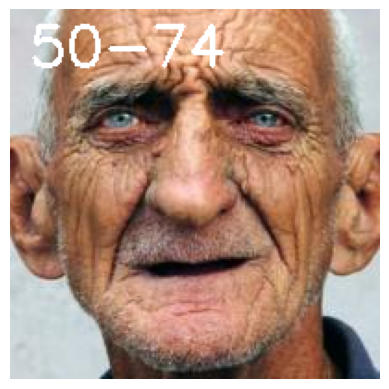

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


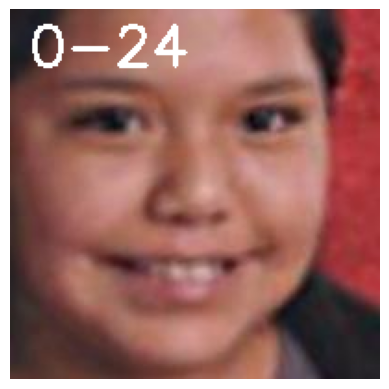

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


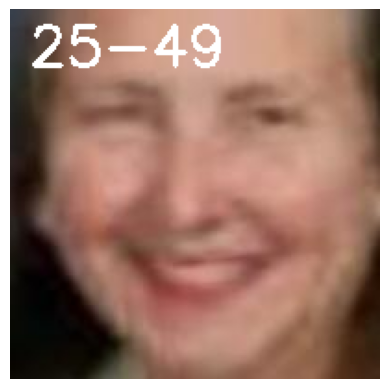

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


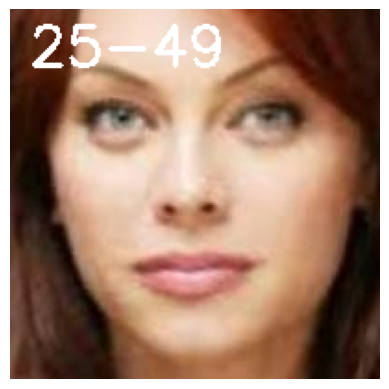

In [17]:
# New path of the sample image dataset
new_sample_dir = "test_examples"

# All sample image names in the new directory
new_sample_img_names = os.listdir(new_sample_dir)

for counter, new_sample_img_name in enumerate(new_sample_img_names):
    # Path of the selected image
    new_sample_path = os.path.join(new_sample_dir, new_sample_img_name)

    # Get the prediction
    predicted_age_class = predict_on_image(new_sample_path)

    # Read sample image in BGR format
    new_sample_img_bgr = cv2.imread(new_sample_path)

    # Convert it into RGB format
    new_sample_img_rgb = cv2.cvtColor(new_sample_img_bgr, cv2.COLOR_BGR2RGB)

    # Write predicted age class on top of the image
    cv2.putText(new_sample_img_rgb, predicted_age_class, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the selected image
    plt.imshow(new_sample_img_rgb)
    plt.axis('off')
    plt.show()

### The end!

### P.S. Brain age prediction 

For a more technical and involved case study, see https://www.medrxiv.org/content/10.1101/2022.09.06.22279594v2.full.pdf for an example of age prediction from brain MRI images. The source code and model weights are available at https://github.com/westman-neuroimaging-group/brainage-prediction-mri . 

